# Model Classification of Convective Mode

In [1]:
import numpy as np
import pandas as pd
import glob

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline

2024-04-28 00:59:03.231061: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-28 00:59:03.231131: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-28 00:59:03.231191: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-28 00:59:03.243591: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load CSV and Model

In [2]:
#load the csvs
epoch = 'END4p5'
year = 2095

df = pd.concat(map(pd.read_csv, glob.glob(f'/share/jcorner_data/csvs/{epoch}/*{year}*')), ignore_index=True)
df

,Unnamed: 0,x,y,Filename,Time
0,0,676,221,03112095_T21_0id.npy,2095-03-11T21:00:00.000000000
1,1,665,198,03122095_T01_1id.npy,2095-03-12T01:00:00.000000000
2,2,700,135,03122095_T20_2id.npy,2095-03-12T20:00:00.000000000
3,3,703,128,03122095_T21_3id.npy,2095-03-12T21:00:00.000000000
4,4,703,129,03122095_T21_4id.npy,2095-03-12T21:00:00.000000000
...,...,...,...,...,...
14193,25,681,616,10312095_T04_25id.npy,2095-10-31T04:00:00.000000000
14194,26,681,617,10312095_T04_26id.npy,2095-10-31T04:00:00.000000000
14195,27,694,631,10312095_T05_27id.npy,2095-10-31T05:00:00.000000000
14196,28,726,704,10312095_T07_28id.npy,2095-10-31T07:00:00.000000000


In [3]:
#load the CNN model
model = keras.models.load_model('/share/jcorner_data/models/future_modes_v2.h5')
model.summary()

2024-04-28 00:59:05.980941: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-28 00:59:06.011065: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-28 00:59:06.011219: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 12)      984       
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 24)      23352     
                                                                 
 average_pooling2d (Average  (None, 24, 24, 24)        0         
 Pooling2D)                                                      
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 48)        93360     
                                                                 
 average_pooling2d_1 (Avera  (None, 3, 3, 48)          0         
 gePooling2D)                                                    
                                                                 
 flatten (Flatten)           (None, 432)               0

## Classify Convective Mode

In [4]:
#create a list with the number corresponding to the convective mode.
lookup = {0:'Cellular', 1:'Multicell', 
          2:'Linear', 3:'Other'}

#create the new dataframe with the mode column
new_df = pd.DataFrame(columns=['x', 'y', 'Filename', 'Time', 'Mode'])

modes = []
xs = []
ys = []
filenames = []
times = []

#iterate through all the numpy files in the directory
for rid, row in df[12000:].iterrows():
    
    #isolate the filename from the path and dataframe
    path = f'/share/jcorner_data/storm_images/{epoch}/{row.Filename}'

    #load the file
    file = np.load(path)

    if file.shape == (136, 136):
        
        #normalize the data
        file = file/80
    
        #expand the dimensions to the correct size
        file = np.expand_dims(file, 2)
        file = np.expand_dims(file, 0)
    
        #classify the convective mode using the CNN
        pred = model.predict(file, verbose=None)
        mode = [lookup[x] for x in np.argmax(pred, axis=1)]

        #append values to list
        modes.append(mode[0])
        filenames.append(row.Filename)
        xs.append(row.x)
        ys.append(row.y)
        times.append(row.Time)
        
#apply to dataframe
new_df['Mode'] = modes
new_df['Filename'] = filenames
new_df['x'] = xs
new_df['y'] = ys
new_df['Time'] = times
new_df

2024-04-28 00:59:06.649829: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907


,x,y,Filename,Time,Mode
0,629,212,06162095_T04_1913id.npy,2095-06-16T04:00:00.000000000,Multicell
1,630,212,06162095_T04_1914id.npy,2095-06-16T04:00:00.000000000,Multicell
2,627,213,06162095_T04_1915id.npy,2095-06-16T04:00:00.000000000,Multicell
3,628,213,06162095_T04_1916id.npy,2095-06-16T04:00:00.000000000,Multicell
4,627,216,06162095_T04_1917id.npy,2095-06-16T04:00:00.000000000,Multicell
...,...,...,...,...,...
2193,681,616,10312095_T04_25id.npy,2095-10-31T04:00:00.000000000,Cellular
2194,681,617,10312095_T04_26id.npy,2095-10-31T04:00:00.000000000,Cellular
2195,694,631,10312095_T05_27id.npy,2095-10-31T05:00:00.000000000,Cellular
2196,726,704,10312095_T07_28id.npy,2095-10-31T07:00:00.000000000,Cellular


In [5]:
#save the dataframe to a csv
new_df.to_csv(f'/share/jcorner_data/csvs/modes/{epoch}/storm_modes_{year}_2_{epoch}.csv')

## Check Model Predictions

<Axes: >

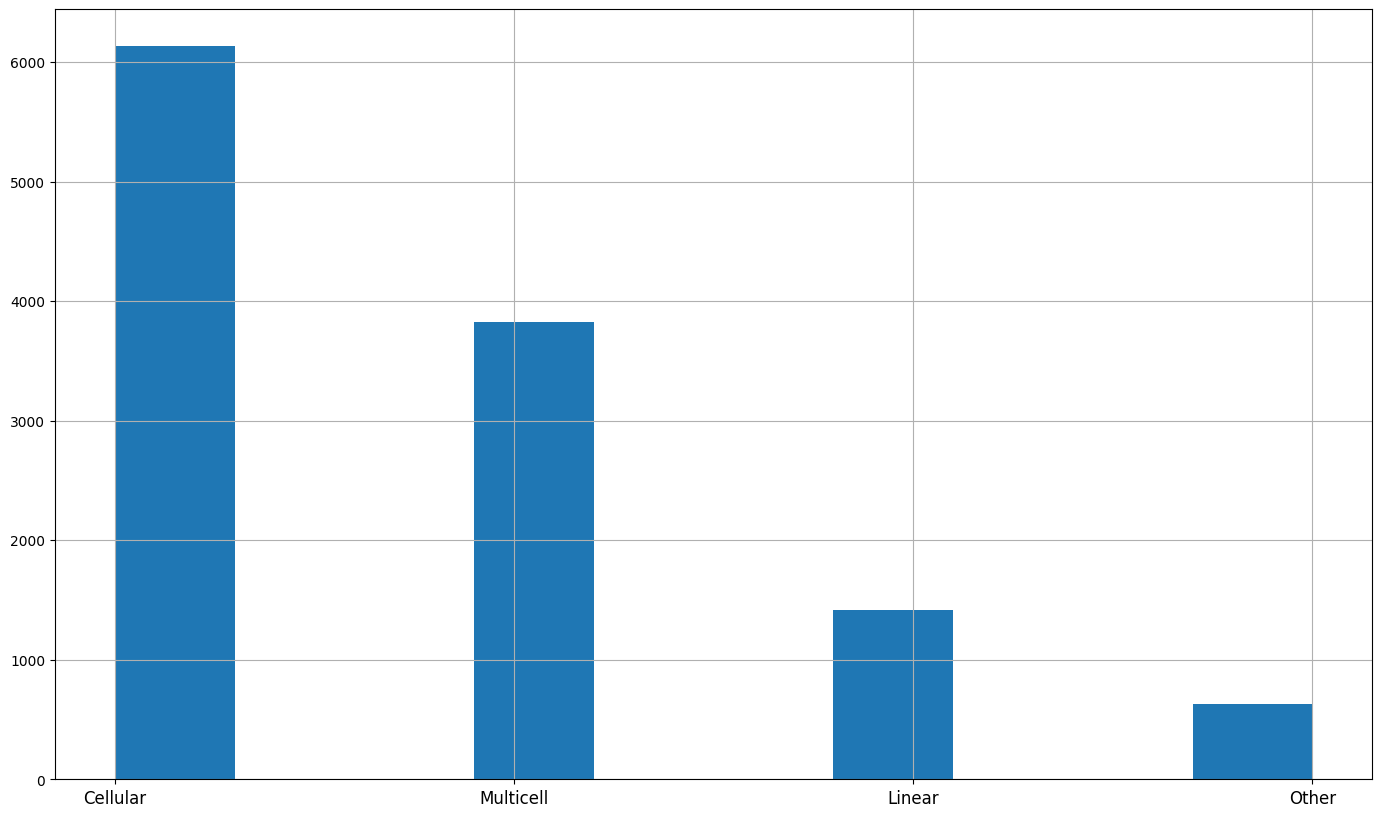

In [6]:
#create a histogram from the predictions
plt.rcParams['figure.figsize'] = 17, 10
new_df.Mode.hist(xlabelsize = 12)

In [7]:
from svrimg.mapping.map_helper import radar_colormap, draw_box_plot
from matplotlib.colors import BoundaryNorm

#load a radarcolormap
cmap = radar_colormap()
classes = np.array(list(range(0, 85, 5)))
norm = BoundaryNorm(classes, ncolors=cmap.N)

#iterate through each class
for i in range(6):
    ax = plt.subplot(2,3,i+1)

    #find a random image for each class and annotate the class
    sample = np.load(f"/shared/shared/jcorner_data/eoc8p5/{new_df[(new_df['Mode'] == lookup[i])].sample()['Filename'].values[0]}")
    ax.annotate(f'{lookup[i]}', (0.03,0.05),fontsize=15, 
                        bbox=dict(boxstyle='round', facecolor='w', alpha=1), xycoords='axes fraction')

    #plot the data
    draw_box_plot(ax, sample.squeeze())

ModuleNotFoundError: No module named 'svrimg'